In [1]:
import os
import time
import traceback
import numpy as np
import pandas as pd
from dataloader import TrimodalLoader
from model import TrimodalModel
import torch


## Process
1. Load all data
2. Sub or oversample so that all dataset samples align
3. Form inputs of shape [mod1_x, mod2_x, mod3_x], [y]
4. Train embracenet

In [2]:
def load_iris():
    """Loads iris features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../iris/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"iris_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels
        

In [3]:
def load_fingerprint():
    """Loads fingerprint features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../fingerprint/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"fp_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels

In [4]:
def load_face():
    """Loads face features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../face/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"face_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels

In [5]:
if len(os.listdir("feats")) == 0:
    emb_iris, lab_iris = load_iris()
    emb_fp, lab_fp = load_fingerprint()
    emb_face, lab_face = load_face()
else:
    emb_iris = pd.read_csv("feats/iris.csv")
    emb_fp = pd.read_csv("feats/fingerprint.csv")
    emb_face = pd.read_csv("feats/face.csv")

In [6]:
if len(os.listdir("feats")) == 0:

    print(len(lab_iris), len(lab_fp), len(lab_face))
    emb_iris["label"] = lab_iris
    emb_fp["label"] = lab_fp
    emb_face["label"] = lab_face

    emb_iris.to_csv("feats/iris.csv", index=False)
    emb_fp.to_csv("feats/fingerprint.csv", index=False)
    emb_face.to_csv("feats/face.csv", index=False)

else:
    emb_iris = pd.read_csv("feats/iris.csv")    
    emb_fp = pd.read_csv("feats/fingerprint.csv")
    emb_face = pd.read_csv("feats/face.csv")

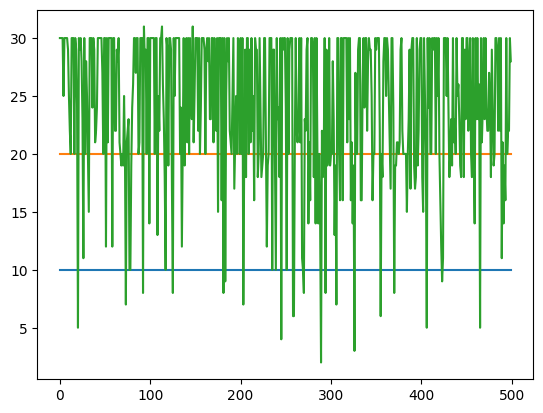

In [7]:
import matplotlib.pyplot as plt
plt.plot(emb_iris["label"].value_counts().sort_index())
plt.plot(emb_fp["label"].value_counts().sort_index())
plt.plot(emb_face["label"].value_counts().sort_index()) 

In [8]:
def get_fusion(df1, df2, df3):
    """
    Concatenates three dataframes into a single dataframe with pairs of embeddings and labels.

    Parameters:
        df1, df2, df3 (pd.DataFrame): DataFrames containing embeddings and labels.
        
    Returns:
        pd.DataFrame: A concatenated DataFrame with balanced pairs of embeddings and labels.
    """
    final_df1 = pd.DataFrame()
    final_df2 = pd.DataFrame()
    final_df3 = pd.DataFrame()
    
    
    # Iterate over unique labels
    for label in df1['label'].unique():
        # Filter each DataFrame for the current label
        sub_df1 = df1[df1['label'] == label]
        sub_df2 = df2[df2['label'] == label]
        sub_df3 = df3[df3['label'] == label]
        
        # Determine the maximum number of samples across the three DataFrames
        num_samples = max(len(sub_df1), len(sub_df2), len(sub_df3))
        
        # Oversample each subset to match the maximum sample size
        sub_df1 = sub_df1.sample(num_samples, replace=True).reset_index(drop=True)
        sub_df2 = sub_df2.sample(num_samples, replace=True).reset_index(drop=True)
        sub_df3 = sub_df3.sample(num_samples, replace=True).reset_index(drop=True)
        
        final_df1 = pd.concat([final_df1, sub_df1], axis=0)
        final_df2 = pd.concat([final_df2, sub_df2], axis=0)
        final_df3 = pd.concat([final_df3, sub_df3], axis=0)
        
    
    return final_df1, final_df2, final_df3


In [9]:
def remap_labels(emb_iris, emb_face, emb_fp):
    mapping = {val: idx for idx, val in enumerate(emb_iris["label"].unique())}
    
    emb_iris["label"] = emb_iris["label"].map(mapping)
    emb_face["label"] = emb_face["label"].map(mapping)
    emb_fp["label"] = emb_fp["label"].map(mapping)
    
    return emb_iris, emb_face, emb_fp

In [10]:
if "iris_sampled.csv" not in os.listdir("feats"):
    emb_iris, emb_face, emb_fp = get_fusion(emb_iris, emb_face, emb_fp)
    
    emb_iris, emb_face, emb_fp = remap_labels(emb_iris, emb_face, emb_fp)
    
    emb_iris.to_csv("feats/iris_sampled.csv", index=False)
    emb_fp.to_csv("feats/fingerprint_sampled.csv", index=False)
    emb_face.to_csv("feats/face_sampled.csv", index=False)

else:
    emb_iris = pd.read_csv("feats/iris_sampled.csv")
    emb_fp = pd.read_csv("feats/fingerprint_sampled.csv")
    emb_face = pd.read_csv("feats/face_sampled.csv")

In [11]:
len(emb_iris), len(emb_face), len(emb_fp)

(12603, 12603, 12603)

In [12]:
# Prepare dataloader
train_subjects_uniq = len(emb_iris["label"].unique()) // 5
train_subjects = emb_iris["label"].unique()[:train_subjects_uniq]
test_subjects = emb_iris["label"].unique()[train_subjects_uniq:]

iris_train = emb_iris[emb_iris["label"].isin(train_subjects)]
fp_train = emb_fp[emb_fp["label"].isin(train_subjects)]
face_train = emb_face[emb_face["label"].isin(train_subjects)]


iris_test = emb_iris[emb_iris["label"].isin(test_subjects)]
fp_test = emb_fp[emb_fp["label"].isin(test_subjects)]
face_test = emb_face[emb_face["label"].isin(test_subjects)]


iris_train_x, iris_train_y = iris_train.drop("label", axis=1), iris_train["label"]
fp_train_x, fp_train_y = fp_train.drop("label", axis=1), fp_train["label"]
face_train_x, face_train_y = face_train.drop("label", axis=1), face_train["label"]


iris_test_x, iris_test_y = iris_test.drop("label", axis=1), iris_test["label"]
fp_test_x, fp_test_y = fp_test.drop("label", axis=1), fp_test["label"]
face_test_x, face_test_y = face_test.drop("label", axis=1), face_test["label"]

In [13]:
iris_train = iris_train.drop(columns="label")

In [14]:
list(iris_train_y)[:10], list(fp_train_y)[:10], list(face_train_y)[:10]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
len(iris_train_y), len(fp_train_y), len(face_train_y)

(2638, 2638, 2638)

In [16]:
list(iris_train_y) == list(fp_train_y) == list(face_train_y)

True

In [17]:
list(iris_test_y) == list(fp_test_y) == list(face_test_y)

True

In [18]:
# We only need one set of labels
y = iris_train_y

In [19]:
dataloader = TrimodalLoader(
    torch.tensor(iris_train_x.values, dtype=torch.float32), 
    torch.tensor(fp_train_x.values, dtype=torch.float32), 
    torch.tensor(face_train_x.values, dtype=torch.float32), 
    torch.tensor(list(y), dtype=torch.long))

test_loader = TrimodalLoader(
    torch.tensor(iris_test_x.values, dtype=torch.float32), 
    torch.tensor(fp_test_x.values, dtype=torch.float32), 
    torch.tensor(face_test_x.values, dtype=torch.float32), 
    torch.tensor(list(y), dtype=torch.long))

In [20]:
iris_train_y

0        0
1        0
2        0
3        0
4        0
        ..
2633    99
2634    99
2635    99
2636    99
2637    99
Name: label, Length: 2638, dtype: int64

In [21]:
iris_train.iloc[0].shape

(1408,)

In [22]:
# initialize
batch_size = 32
device = "cpu"
train_path = "tmp/train/"
max_steps = 100
log_freq = 2
summary_freq = 5
save_freq = 5
sleep_ratio = 0
restore_path = None
global_step = 0
os.environ["CUDA_VISIBLE_DEVICES"] = device
os.makedirs(train_path, exist_ok=True)

In [23]:
# Prepare model
model = TrimodalModel()
input_size_list = [iris_train.iloc[0].shape[0], fp_train_x.iloc[0].shape[0], face_train_x.iloc[0].shape[0]]
print(input_size_list)

print(input_size_list)
n_classes = iris_train_y.nunique()
print("N classes: ", n_classes)
model.prepare(is_training=True, input_size_list=input_size_list, global_step=global_step, n_classes=n_classes)

[1408, 1408, 512]
[1408, 1408, 512]
N classes:  100
Created docking_0 with input size 1408 and output size 256
Parameter containing:
tensor([[-0.0037, -0.0069,  0.0056,  ..., -0.0189,  0.0047,  0.0031],
        [ 0.0089,  0.0183, -0.0040,  ...,  0.0223, -0.0138,  0.0107],
        [-0.0206, -0.0009,  0.0224,  ..., -0.0173,  0.0055, -0.0262],
        ...,
        [-0.0257, -0.0254,  0.0052,  ..., -0.0246, -0.0058,  0.0209],
        [-0.0091,  0.0044, -0.0120,  ...,  0.0213,  0.0247,  0.0171],
        [ 0.0186, -0.0125, -0.0176,  ...,  0.0244,  0.0154,  0.0198]],
       requires_grad=True)
Created docking_1 with input size 1408 and output size 256
Parameter containing:
tensor([[ 0.0264, -0.0102,  0.0215,  ...,  0.0190,  0.0005,  0.0026],
        [ 0.0231, -0.0200, -0.0136,  ..., -0.0060,  0.0052, -0.0028],
        [ 0.0243, -0.0086, -0.0108,  ..., -0.0247,  0.0065,  0.0164],
        ...,
        [-0.0037, -0.0202, -0.0241,  ..., -0.0103,  0.0115, -0.0047],
        [-0.0103,  0.0041, -0.02

In [24]:
# model > restore
if restore_path is not None:
    model.restore(ckpt_path=restore_path)
    print("restored the model")

# model > summary
summary_path = os.path.join(train_path, "summary")

In [25]:
iris_train.iloc[0].shape, fp_train_x.iloc[0].shape, face_train_x.iloc[0].shape

((1408,), (1408,), (512,))

In [26]:
print("begin training")
local_train_step = 0
losses = []
while model.global_step < max_steps:
    global_train_step = model.global_step + 1
    local_train_step += 1

    start_time = time.time()


    input_list, truth_list = dataloader.get_batch(
        batch_size=batch_size
    )  # [mod1, mod2, ...], label
    truth_list = torch.as_tensor(
        [int(label) for label in truth_list],  # Convert NumPy scalar arrays to Python integers
        dtype=torch.long,
        device=device)
    
    print(truth_list)
    loss = model.train_step(
        input_list=input_list, truth_list=truth_list
    )
    losses.append(loss)
    print(loss)
    duration = time.time() - start_time

    if local_train_step % log_freq == 0:
        print(
            "step %d, loss %.6f (%.3f sec/batch)"
            % (global_train_step, loss, duration)
        )

    if local_train_step % save_freq == 0:
        model.save(base_path=train_path)
        print("saved a model checkpoint at step %d" % (global_train_step))

# except KeyboardInterrupt:
#     print("interrupted (KeyboardInterrupt)")
# except Exception as e:
#     print(traceback.format_exc())

# finalize
print("finished")


begin training
tensor([43, 95, 84, 66, 38, 34, 37, 51, 91, 18, 16, 60, 56,  3, 59, 84,  2, 57,
        45, 43, 10, 59, 49, 39, 94, 11, 55, 77, 71, 59, 71, 98])
Selection probabilities:  tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]])
Modality indices (r_i):  tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0

TODO: Save embracenet weights and get output. 

In [27]:
while True:
    input_list, truth_list = test_loader.get_batch(
        batch_size=32
    )
    
    outputs = model.predict(input_list)
    
    print(input_list)
    print(truth_list)
    break

c:\Users\sebas\Desktop\repos\multimodal_person_recognition\src\embracenet\model.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  input_tensor = torch.tensor(input_list, dtype=torch.float32, device=self.device)


ValueError: expected sequence of length 1408 at dim 2 (got 512)

In [ ]:
45056 / 256

176.0

In [ ]:
torch.cuda.is_available()

False

In [ ]:
input_size_list

[1408, 1408, 512]

In [ ]:
512 * 32

16384

Text(0.5, 1.0, 'EmbraceNet Loss')

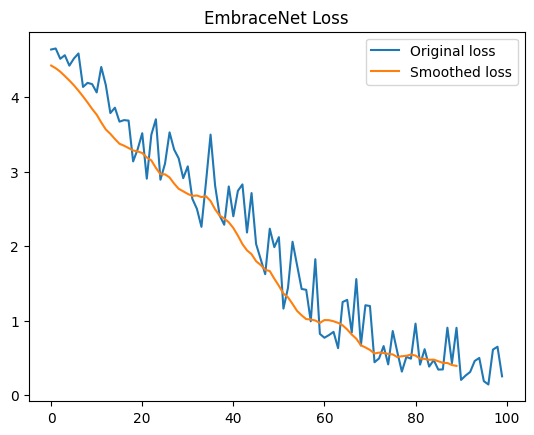

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
# Function to create a Gaussian kernel
def gaussian_kernel(size, sigma=1):
    x = np.linspace(-size // 2, size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

sigma = 5
kernel_size = 11  # Choose an odd number
kernel = gaussian_kernel(kernel_size, sigma)
smoothed_vector = np.convolve(losses, kernel, mode='same')

plt.plot(losses, label="Original loss")
plt.plot(smoothed_vector[5:-5], label="Smoothed loss")
plt.legend()
plt.title("EmbraceNet Loss")
